### Vector Store 사용하는 방식 크게 두가지
1. faiss library 사용
2. langchain 사용

In [3]:
# !pip install faiss-gpu

### 1. faiss 사용 sample

In [1]:
import numpy as np
import faiss

In [2]:
# 예제 데이터 생성
data = np.random.random((10000, 128)).astype('float32')

# Faiss 인덱스 생성
index = faiss.IndexFlatL2(128)  # L2 거리를 사용하는 인덱스 

# 데이터를 인덱스에 추가
index.add(data)

In [3]:
# 검색할 쿼리 벡터 생성
query_vector = np.random.random((1, 128)).astype('float32')
print(query_vector.shape)

# 검색 실행 (query_vector과 가까운 데이터 k개 추출 (L2 기반))
k = 5  
D, I = index.search(query_vector, k)

# 결과 출력
print("가장 가까운 이웃의 거리:", D)
print("가장 가까운 이웃의 인덱스:", I)

(1, 128)
가장 가까운 이웃의 거리: [[15.151188  15.2391615 15.378507  15.3864355 15.456718 ]]
가장 가까운 이웃의 인덱스: [[3837 3854 9477 1709 8232]]


### 2. Langchain 사용
- Langchain에서 다양한 vector store 관련된 다양한 코드 제공
- https://python.langchain.com/docs/integrations/vectorstores
- (1) 데이터 로드
- (2) 데이터 처리
- (3) vector store에 넣을 docs 및 임베딩 지정
- (4) vector store 생성 및 저장
- (5) 테스트

(1) 데이터 로드

In [4]:
import pandas as pd
df = pd.read_excel("testdata.xlsx")
df = df[["t_job_code","train_title","train_contents"]]
df.head()

,t_job_code,train_title,train_contents
0,231100,[원패스] 사회복지사 1급 필기시험 대비 단과반(사회복지 실천),{'훈련목표': '1. 사회복지 실천 현장에서 실천기술을 함양을 위해 사회복지사가 ...
1,231400,[원패스] 직업상담사 2급 필기 1(직업상담학+직업심리학+노동시장론),{'훈련목표': '직업상담사에 대한 이론 지식을 습득한다.\n직업상담사 관련 용어를...
2,31100,토마토패스 신용분석사 2부 자격대비과정,{'훈련목표': '1. 신용분석사 2부 자격증의 주요내용을 이해할 수 있다.2. 신...
3,134900,[상위1% 빅데이터 ] 기업이 주목하는 Hadoop 제대로 배우기,"{'훈련목표': '빅데이터 용어에 대한 이해를 시작으로 HDFS, YARN 을 통한 하"
4,26100,작은 아이디어로 만드는 연매출 3조 경영 성공 전략,{'훈련목표': '1) 아이디어를 성공시키는 경영 핵심 전략에 대해 설명할 수 있다...


(2) 데이터 처리, (3) Docs 및 임베딩 지정

In [5]:
# 데이터 수집
import ast
text_lst = []
for idx in range(len(df)):
    try:
        # ast를 사용해서 문자열로 된 딕셔너리를 Python 딕셔너리 객체로 변환후 텍스트 결합
        insert_text = f"직업훈련중 <{df.loc[idx]['train_title']}>의 훈련목표는 다음과 같습니다."
        insert_text += ast.literal_eval(df.loc[idx]["train_contents"])["훈련목표"]
        text_lst.append(insert_text)
    except:
        pass

# vector store에 넣을 docs 생성
# 트러블슈팅 출처 : https://github.com/langchain-ai/langchain/issues/3799
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.create_documents(text_lst)

# 임베딩 지정 (허깅페이스)
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# 임베딩 지정 (openai embedding 사용)
from langchain.embeddings.openai import OpenAIEmbeddings
'''
embeddings = OpenAIEmbeddings()
api_key = "<본인 api key 사용>"
os.environ["OPENAI_API_KEY"] = api_key
'''

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'\nembeddings = OpenAIEmbeddings()\napi_key = "<본인 api key 사용>"\nos.environ["OPENAI_API_KEY"] = api_key\n'

(4) Vector Store 생성 및 저장

In [7]:
# Vector Store 생성 및 저장
import os
from langchain.vectorstores import FAISS

VECTOR_STORE_PATH = "DB/faiss_ver1"
if os.path.exists(VECTOR_STORE_PATH):
    print("해당 경로에 이미 vector store가 있습니다. 해당 vector store를 가져옵니다.")
    db = FAISS.load_local("DB/faiss_ver1", embeddings)
else:
    print('해당 경로에 vector store가 없으므로, 생성 및 저장합니다.')
    db = FAISS.from_documents(docs, embeddings) 
    db.save_local("DB/faiss_ver1")

해당 경로에 이미 vector store가 있습니다. 해당 vector store를 가져옵니다.


(5) 테스트
- similarity_search : 점수 없이 반환
- similarity_search_with_score : 점수 포함하여 반환

In [8]:
# 테스트 
query = "인공지능 관련 직업교육"
result_1 = db.similarity_search(query)
result_2 = db.similarity_search_with_score(query,k=10)

In [9]:
import pprint
pprint.pprint(result_1)
print('-'*20)
print(result_1[0].page_content)

[Document(page_content='직업훈련중 <전기기기제작 기술자 향상과정>의 훈련목표는 다음과 같습니다.-'),
 Document(page_content='직업훈련중 <저탄소 녹색성장을 위한 도시조경>의 훈련목표는 다음과 같습니다.-'),
 Document(page_content='직업훈련중 <탄소중립 도시조성을 위한 조경실무자 양성과정>의 훈련목표는 다음과 같습니다.-'),
 Document(page_content='직업훈련중 <업무가100배빨라지는엑셀함수와데이터관리>의 훈련목표는 다음과 같습니다.-수식과함수및여러엑셀의기능을이용하여효과적인작업을할수있다-업무에필요한자료를수집하고분석․가공하여목적에맞게분석할수있다')]
--------------------
직업훈련중 <전기기기제작 기술자 향상과정>의 훈련목표는 다음과 같습니다.-


### 3. 시각화

In [12]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
# 일부 데이터에 대해 진행할경우
queries_1 = [i.page_content for i in db.similarity_search("유튜브",20)]
query_embedding_1 = np.array([embeddings.embed_query(i) for i in queries_1])
queries_2 = [i.page_content for i in db.similarity_search("데이터",20)]
query_embedding_2 = np.array([embeddings.embed_query(i) for i in queries_2])
queries_3 = [i.page_content for i in db.similarity_search("자동차",20)]
query_embedding_3 = np.array([embeddings.embed_query(i) for i in queries_3])

# "유튜브" + "데이터" 키워드 결합
query_embedding_4 = [i*0.5+j*0.5 for i,j in zip(query_embedding_1,query_embedding_2)]

# embedding vectors 
embeddings_vectors = np.vstack((query_embedding_1, query_embedding_2, query_embedding_3, query_embedding_4))

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_79568/1561047745.py:27: UserWarning: *c* argument looks like a sin

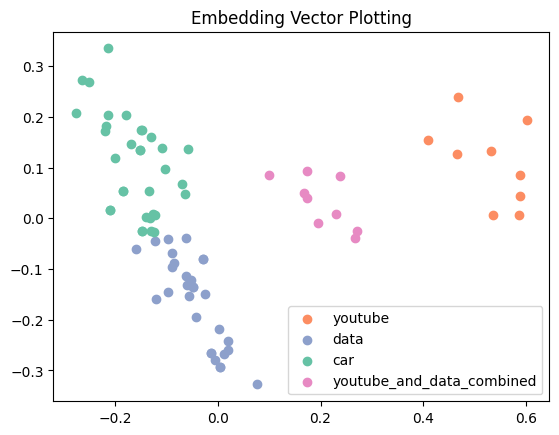

In [15]:
# PCA를 사용하여 차원을 2D로 축소
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embeddings_vectors)

# K-Means 클러스터링
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(reduced_vectors)

# 클러스터별 색상 할당
cluster_colors = sns.color_palette('Set2', n_colors=num_clusters)

# 클러스별 레이블
cluster_lst = []
for i in cluster_labels:
    if i not in cluster_lst:
        cluster_lst.append(i)
    else:
        pass
    
cluster_dict = {i:j for i,j in zip(cluster_lst,['youtube','data','car','youtube_and_data_combined'])}

# 시각화
use_cluster_num = []
for i,cluster_num in zip(range(reduced_vectors.shape[0]),cluster_labels):
    if cluster_num not in use_cluster_num:
        plt.scatter(reduced_vectors[i, 0], 
                    reduced_vectors[i, 1], 
                    c=cluster_colors[cluster_labels[i]],
                    label=cluster_dict[cluster_num])
        use_cluster_num.append(cluster_num)
    else:
        plt.scatter(reduced_vectors[i, 0], 
            reduced_vectors[i, 1], 
            c=cluster_colors[cluster_labels[i]])

plt.title('Embedding Vector Plotting')
plt.legend()
plt.show()